# PROJET SPOTIFY
## I. Analyse et traitement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH='/content/drive/MyDrive/Spotify'

Mounted at /content/drive


## Récupération des données

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import sklearn.manifold
import seaborn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression

subset=pd.read_csv(PATH+'/spotify_dataset_subset.csv')
test=pd.read_csv(PATH+'/spotify_dataset_test.csv')
train=pd.read_csv(PATH+'/spotify_dataset_train.csv')
recommendation=pd.read_csv(PATH+'/recommendation_spotify.csv')

### Nous avons réalisé une transformation sur la colonne dédiée à la date de sortie pour pouvoir rendre les données manipulables. Cette colonne est important à garder (ce qui n'était pas forcémment le cas lors de nos tout premiers esssais) puisque le genre d'une musique est souvent relié à son année de sortie. Nous pouvons prendre l'exemple du "Rock" où ce genre de musique a connu son apogée dans les années 70' et donc pour une musique sortie dans ces années, il y aurait plus de probabilité que cette dernière appartiennent au rock etc.


In [ ]:
import datetime,math

#On transforme la date en différence d'année par rapport à une année de différence 
train['release_date'] = pd.to_datetime(train["release_date"])
train['release_date'] = pd.DatetimeIndex(train['release_date']).year-datetime.datetime(1970,1,1).year

X=train.drop(['genre'],axis=1).to_numpy()
headers=train.drop(['genre'],axis=1).columns
y=train['genre'].to_numpy()
X_test=test.to_numpy()

le = preprocessing.LabelEncoder()
le.fit(y)
y_tr=le.transform(y)
y_label=le.classes_

In [ ]:
train

release_date  explicit  popularity  danceability  energy  key  \
0                45     False          38         0.509  0.8720    2   
1                51     False          58         0.182  0.0377   11   
2                43     False          36         0.550  0.9410    0   
3                42     False           0         0.569  0.7190    6   
4                38     False           0         0.631  0.6610    8   
...             ...       ...         ...           ...     ...  ...   
25487            47     False          30         0.553  0.6990    2   
25488            51     False           8         0.430  0.9880    0   
25489            47     False          71         0.504  0.6550    0   
25490             8     False          27         0.427  0.8800    2   
25491             0     False           0         0.512  0.6080    9   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0        -5.170     1       0.0547      0.039600          0.000015    0.3310   
1       -33.748     0       0.0391      0.987000          0.957000    0.0804   
2        -3.128     0       0.0849      0.018200          0.003750    0.3120   
3        -8.399     0       0.0663      0.867000          0.941000    0.1760   
4        -5.694     1       0.0558      0.014600          0.720000    0.3650   
...         ...   ...          ...           ...               ...       ...   
25487    -4.403     1       0.0572      0.699000          0.000004    0.0996   
25488    -4.442     0       0.1580      0.000043          0.006330    0.3580   
25489    -8.644     0       0.0542      0.604000          0.001930    0.3640   
25490    -5.444     1       0.0494      0.002990          0.000002    0.2250   
25491    -7.472     1       0.0294      0.334000          0.000016    0.0775   

       valence    tempo  duration_ms  time_signature      genre  
0       0.4860   95.969       194375               4    country  
1       0.0923  100.482       241804               4  classical  
2       0.3510  145.006       260276               4        rap  
3       0.6430  145.118       165200               4      blues  
4       0.3300  130.004       245933               4      dance  
...        ...      ...          ...             ...        ...  
25487   0.2260  147.081       192253               4        edm  
25488   0.1220  150.000       194576               4      metal  
25489   0.2620   99.982       264066               4        pop  
25490   0.8560  159.340       102533               4       rock  
25491   0.4490  122.479       227200               4       rock  

[25492 rows x 17 columns]

### Nous avons essayé d'analyser la corrélation entre les caractéristiques des musiques en utilisant seaborn. Nous ne remarquons aucune droite, il n'y a donc aucune de relation linéaire entre deux variables. Mais tout ce qu'on peut en dire c'est que la relation entre ces variables est complexe.

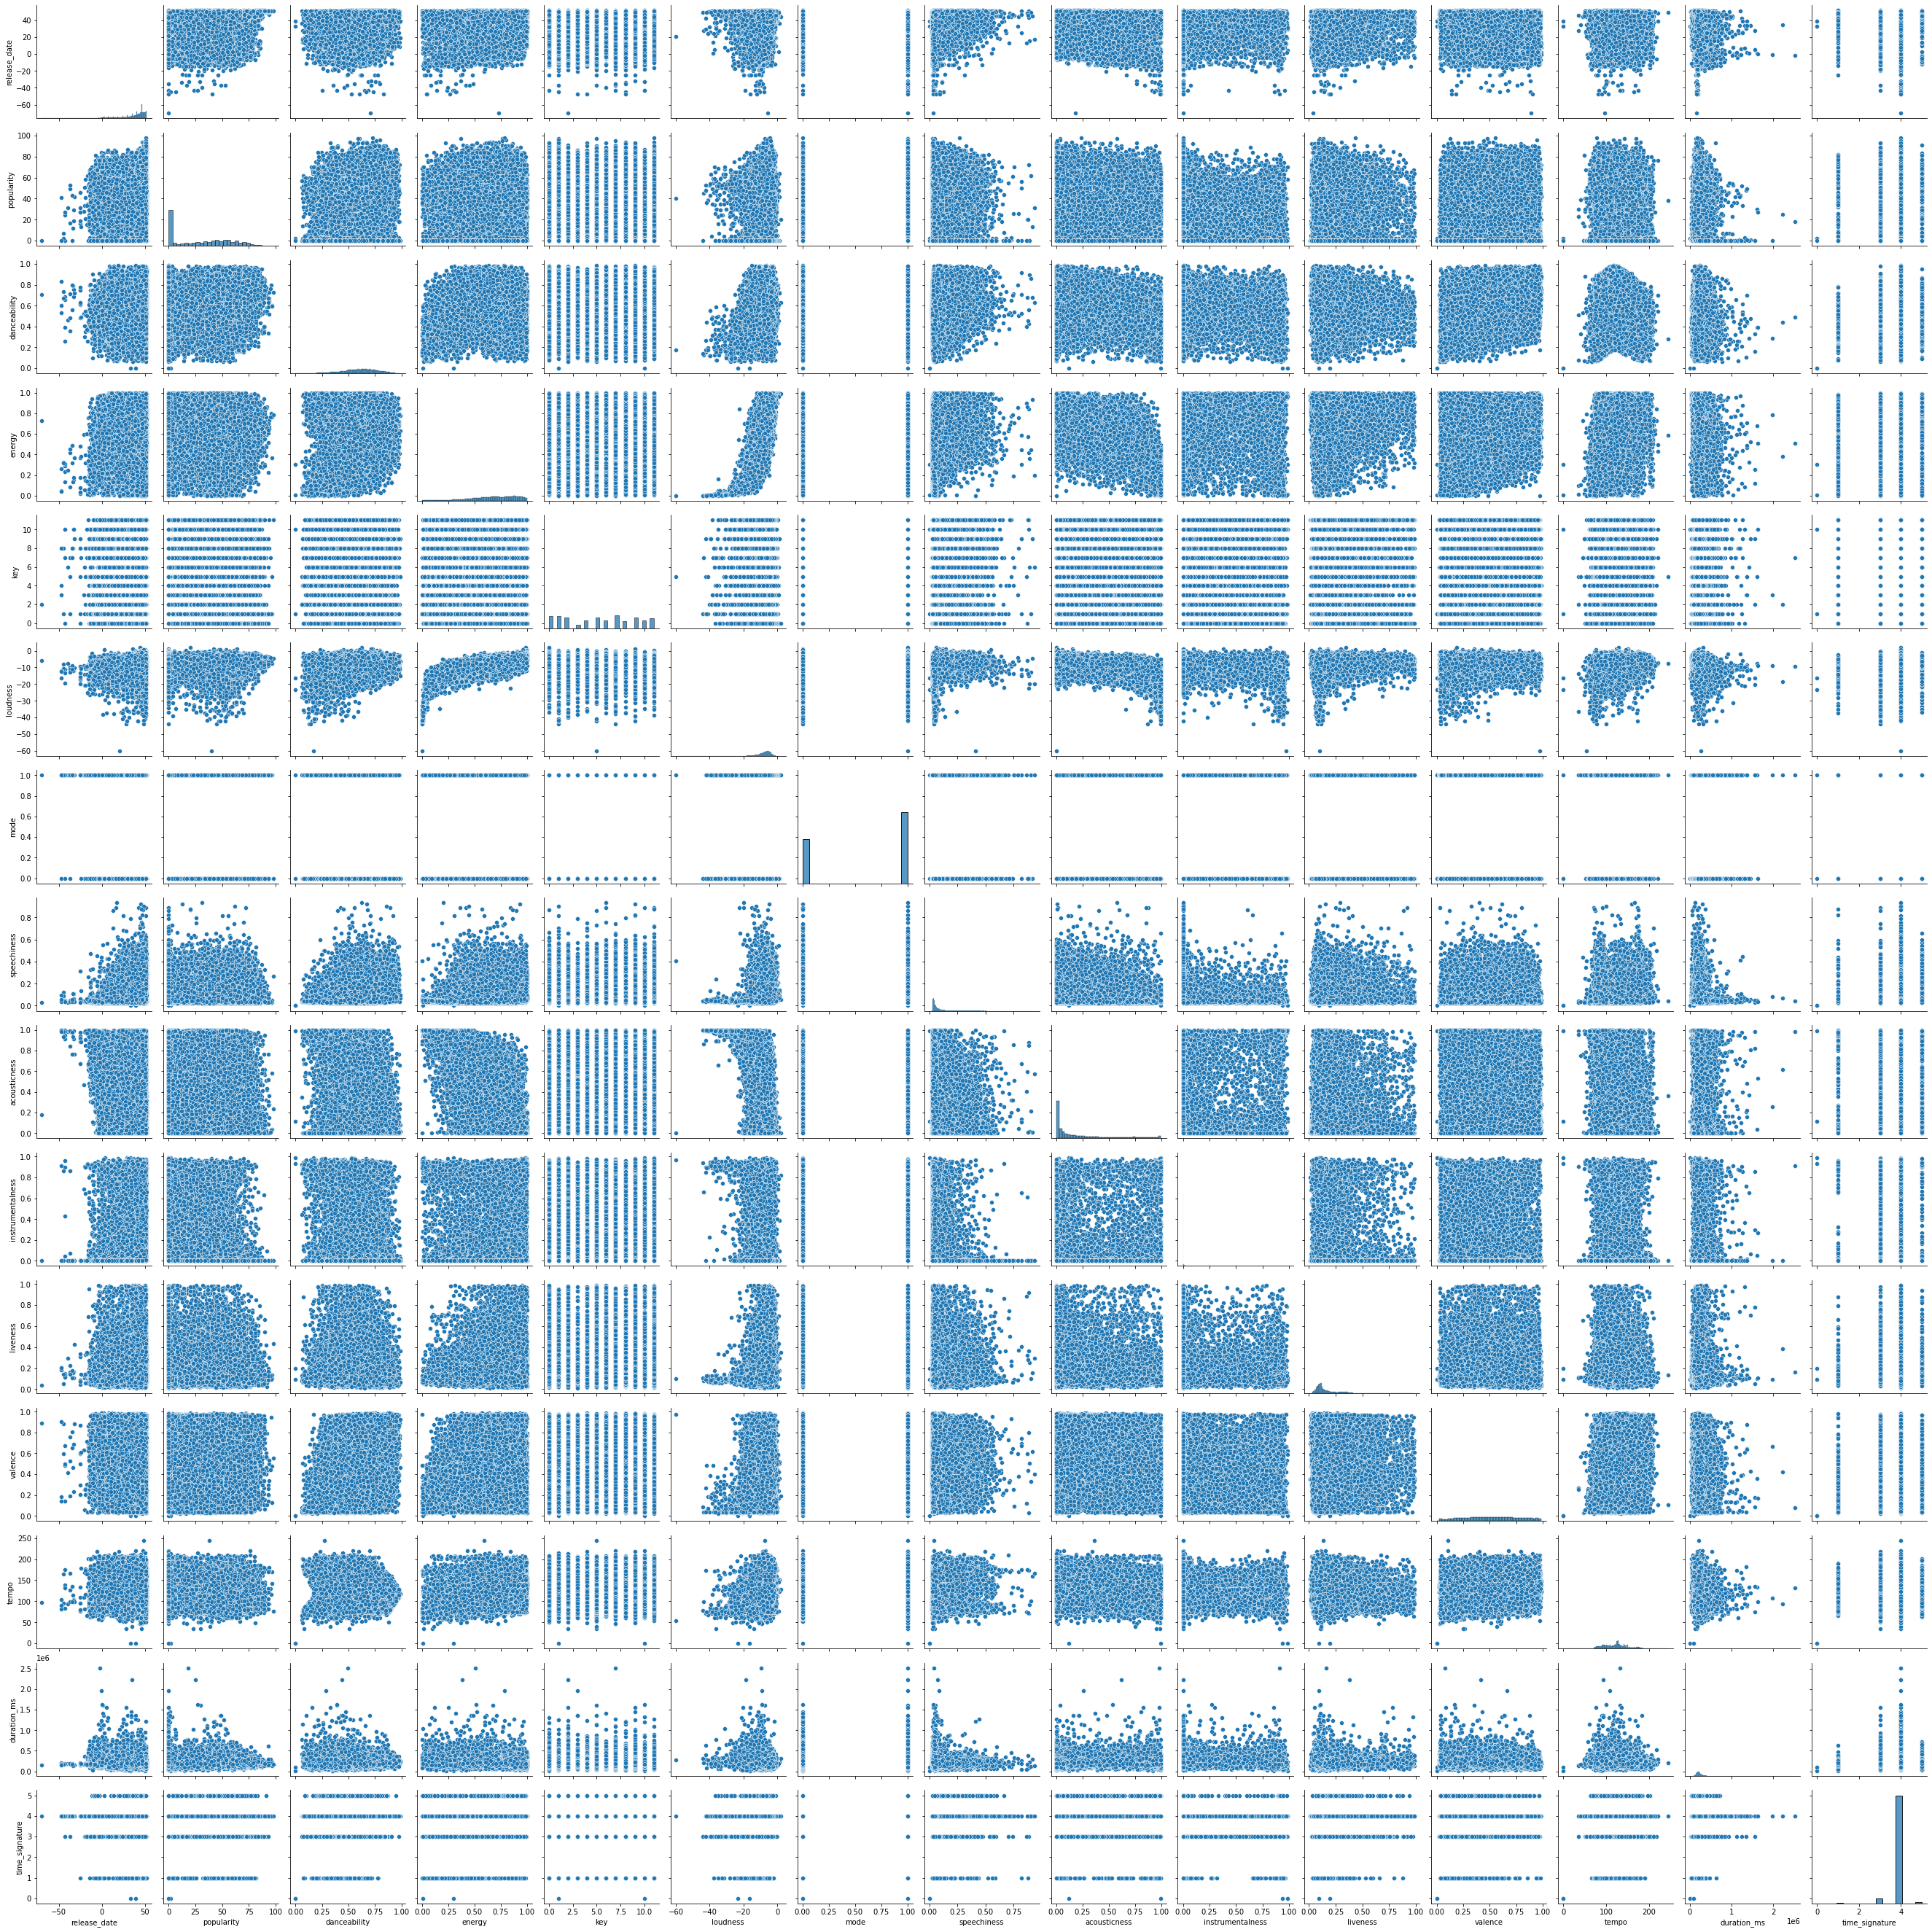

In [ ]:
seaborn.pairplot(train.drop(['explicit'],axis=1))

# I. Challenge classification des genres 
---
## 1. TSNE
### Dans un premier temps, nous avons voulu utiliser le TSNE qui est une technique de réduction de dimension pour visualiser les données et essayer de remarquer des groupes se former par la proximité des points entre eux. Mais malheureusement, en affichant les données dans l'espace formé, on observe qu'il n'y a pas de distinction de groupe par couleur.(Sachant qu'une couleur représente une classe.) On s'attendait à plutôt à des amas de points de même couleur. A l'inverse, les points obtenues sont mélangés pour former des sortes de "ver de terre" dont on ne sait pas comment vraiment interpréter. On peut dire qu'il y a sûrement un autre critère pour pouvoir classifier ces musiques,  qui n'est pas en tout cas le genre, ce qui est recherché ici.


In [ ]:
tsne = sklearn.manifold.TSNE(perplexity = 50)
result = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


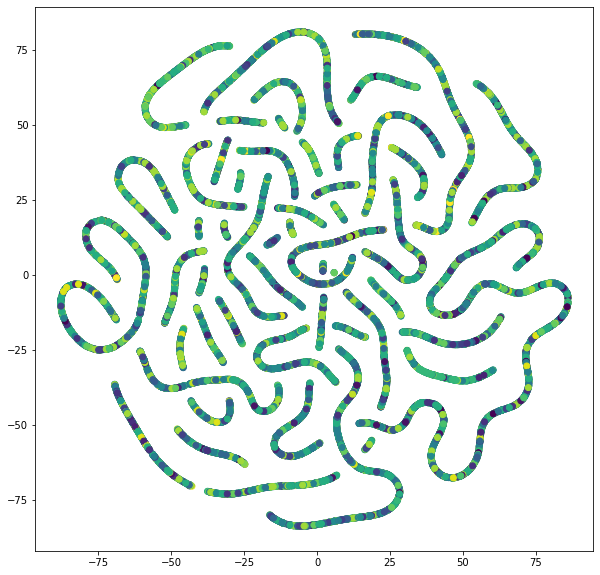

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(result[:,0],result[:,1],c=y_tr)

## 2. Linear Discriminant Analysis
### Dans cette partie, nous allons essayer de trouver un plan dans lequel on va pouvoir distinguer les différentes classes en utilisant la LDA. Cette méthode permet de trouver une combinaison linéaire de plusieurs caractéristiques pour séparer les classes. On va donc suivre le protocole fait dans le premier TP de classification.



In [ ]:
from collections import Counter
j=0
M=[0]*y_label.shape[0]
cnt = Counter()
for i in range(X.shape[0]):
  M[y_tr[i]] += X[i]
  cnt[y_label[y_tr[i]]] += 1 
  
M = [ M[i] /cnt[y_label[i]] for i in range(len(M))]


In [ ]:
S=[np.zeros((16,16))]*22
for i in range(X.shape[0]):
  S[y_tr[i]] = S[y_tr[i]] + (X[i]-M[y_tr[i]]).reshape((-1,1))@(X[i]-M[y_tr[i]]).reshape((1,-1))

In [ ]:
mean_overall = np.zeros((16,))
for i in  range(len(M)):
  mean_overall =  mean_overall  + M[i] *cnt[y_label[i]]
mean_overall = mean_overall / X.shape[0] 

In [ ]:
Sw = np.zeros((16,16))
for s in S:
  Sw = Sw + s

Sw =  Sw / X.shape[0]

In [ ]:
Sb = np.zeros((16,16))
for i in range(len(M)):
  Sb = Sb + cnt[y_label[i]]*(mean_overall-M[i]).reshape((-1,1))@(mean_overall-M[i]).reshape((1,-1))

In [ ]:
from numpy import linalg

matrix=np.linalg.inv(np.float64(Sw))@Sb
print(linalg.eig(np.float64(matrix)))
vector_s = sorted(linalg.eigvals(np.float64(matrix)),reverse=True)
base = linalg.eig(np.float64(matrix))[1][:,0:2]
print(base)
X_trans = X @ base

## Résultat
### On peut remarquer que l'on commence à voir des groupes de classes se former (groupe violet et groupe vert clair). Mais cela reste insuffissant pour classifier les autres classes. Cette méthode pourrait uniquement être utilisé pour classer les points de couleur violet ou vert clair.  

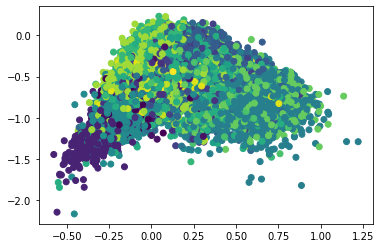

In [ ]:
plt.scatter(*X_trans.T,c=y_tr)

In [ ]:
from  sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA = QuadraticDiscriminantAnalysis()
result=QDA.fit(X,y_tr)
print(QDA.score(X,y_tr))

0.34410795543699985


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## 3. Arbre de decision

### Dans cette partie, nous allons construire des arbres de decision à l'aide DecisionTreeClassifier de sklearn pour pouvoir classer nos musiques.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_tr, test_size=0.2, random_state=42)

### L'arbre formé est complexe est très difficile à interpréter, on va par la suite, essayer de modifier les hyperparamètres de la classe pour obtenir un meilleur score. Après plusieurs tests, nous avons déterminé que le meilleur criterion dans ce problème est "entropy" qui ne procure de meilleurs scores.

[18 18 18 ... 13  9 12]


''

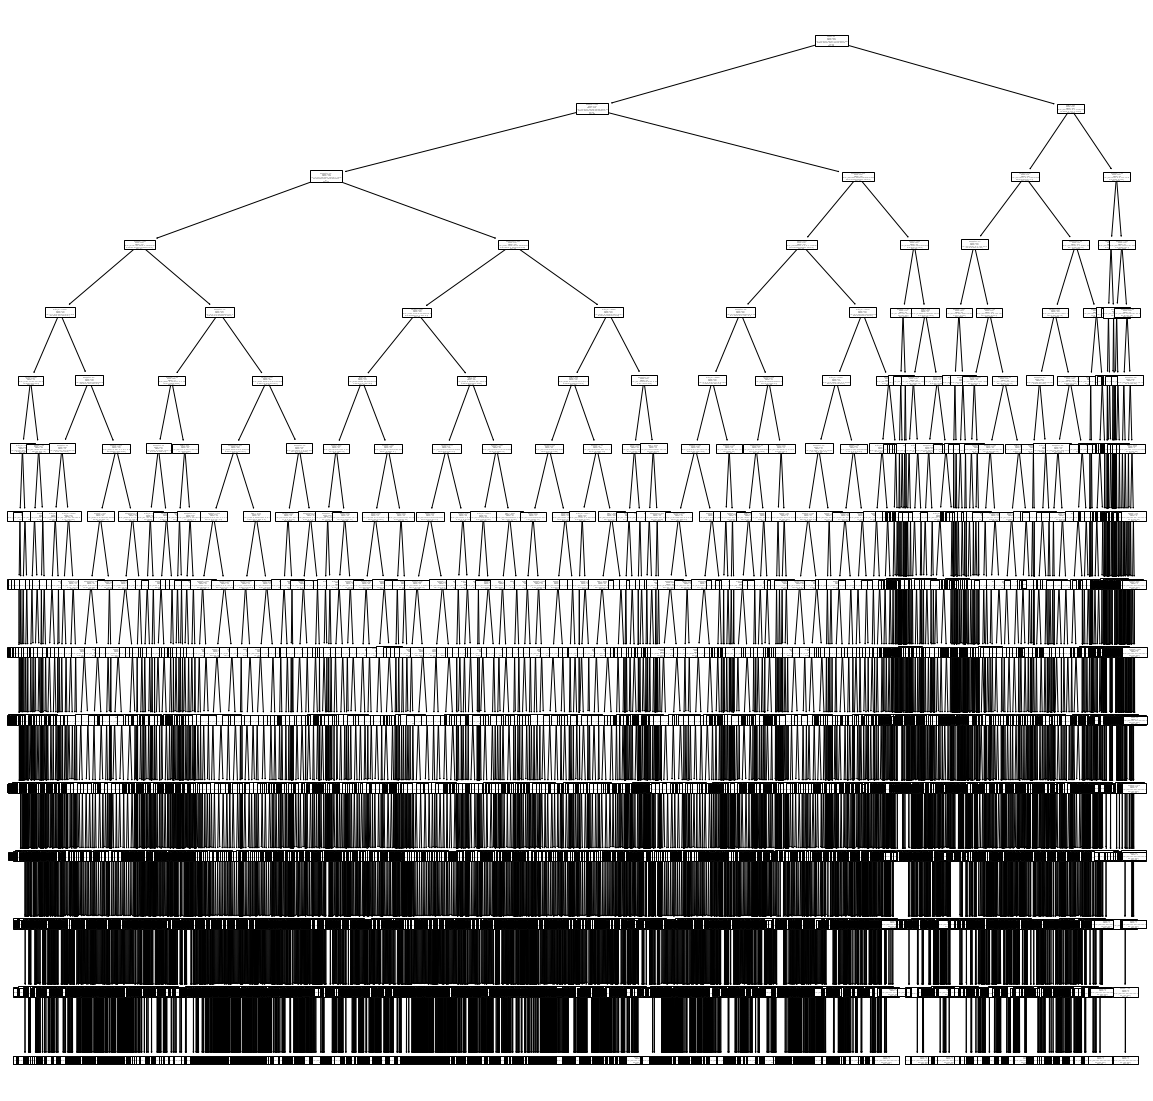

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
clf = DecisionTreeClassifier(criterion='entropy',
                             splitter="best",
                             max_depth=15,#Max depth of the tree 
                             min_samples_split=2,
                             random_state=0,
                             min_weight_fraction_leaf=0,
                             min_impurity_decrease=0)
clf.fit(X_train,y_train)
print(clf.predict(X_test))

plt.figure(figsize=(20,20))
plot_tree(clf,feature_names=headers,class_names=y_label)
;

In [ ]:
X_train

array([[0, False, 58, ..., 90.024, 243800, 4],
       [0, False, 68, ..., 157.044, 255080, 4],
       [0, False, 71, ..., 72.847, 281960, 5],
       ...,
       [0, False, 0, ..., 81.952, 244000, 4],
       [0, False, 18, ..., 127.994, 195306, 4],
       [0, False, 0, ..., 117.04, 195440, 4]], dtype=object)

On obtient un score : 0.34, un score assez faible.
On a affiché l'importance des caractéristiques et on peut voir que la dernière caractéristique qui correspond à la signature times ne semble pas être un élément décisive dans la prise de décision dans l'arbre. 

In [ ]:
print(clf.score(X_test,y_test)) # F1 score avec comme attribut average = 'micro'
print(clf.feature_importances_,np.argmax(clf.feature_importances_))

0.3367326926848402
[0.1136513  0.08472479 0.04457303 0.08700698 0.06050715 0.02566988
 0.05288117 0.00891125 0.08040344 0.12093703 0.07634037 0.03739521
 0.06480115 0.06183643 0.07911485 0.00124597] 9


Après plusieurs tentatives de combinaison d'hyperparamètres, on arrive à ces paramètres ci-dessous qui permet d'avoir un arbre avec beaucoup moins de noeuds et donc plus lisible et aussi à un meilleur f1 score. Un coût de calcul est plus faible ainsi le temps d'éxecution sera plus rapide. C'est un arbre plus simple et qui présente de meilleures performances.

[18 13 18 ... 13 13  9]


''

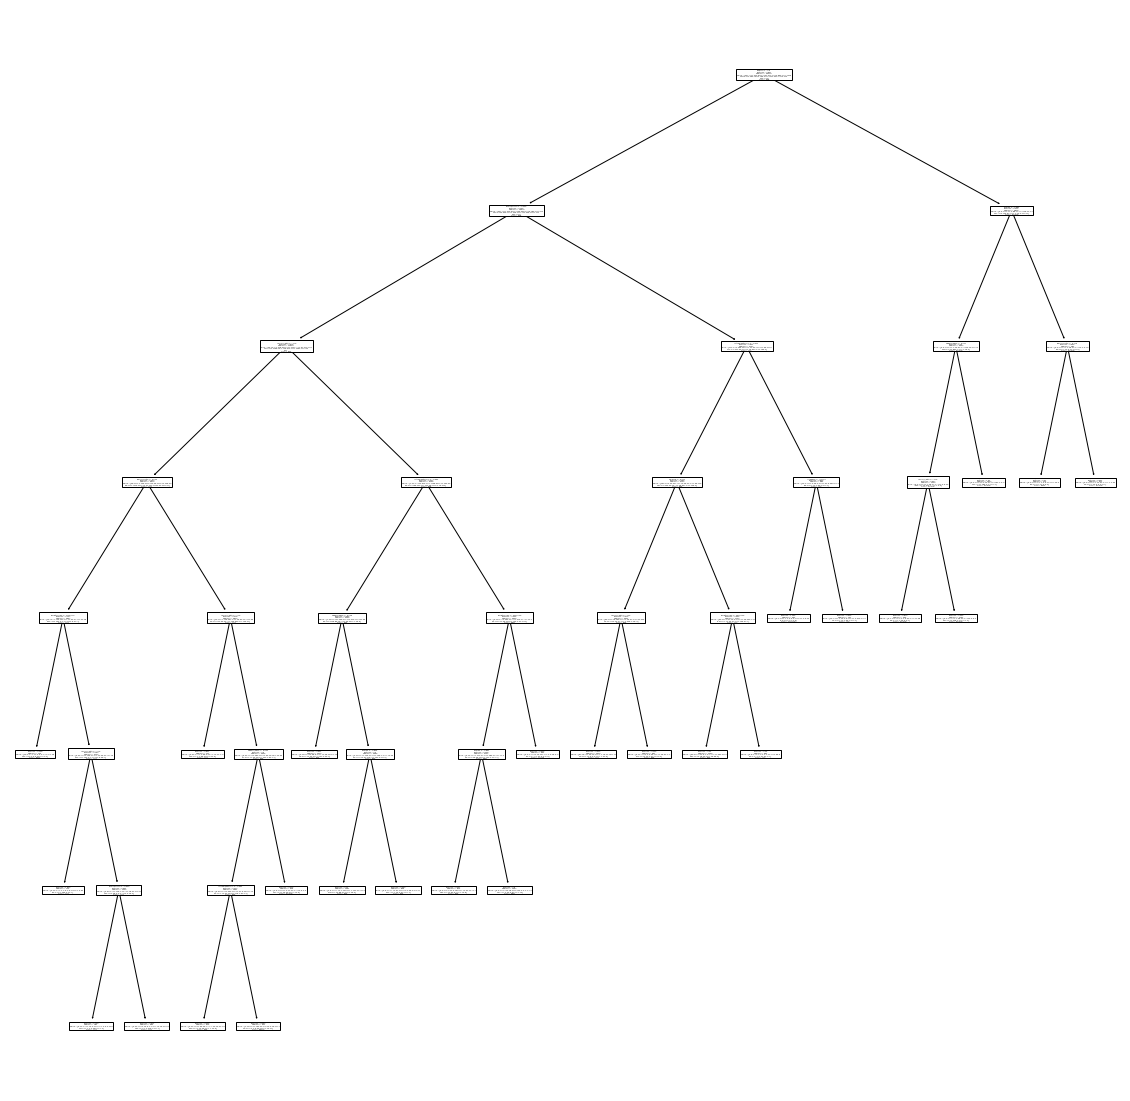

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
clf1 = DecisionTreeClassifier(criterion='entropy',
                             splitter="best",
                             max_depth=15,#Max depth of the tree
                             min_samples_split=2,
                             random_state=0,
                             min_weight_fraction_leaf=0,
                             min_impurity_decrease=0.0082)
clf1.fit(X_train,y_train)
print(clf1.predict(X_test))

plt.figure(figsize=(10,10))
plot_tree(clf1,feature_names=headers,class_names=y_label)
;

In [ ]:
from sklearn.metrics import f1_score
print(clf1.score(X_test,y_test))
print(clf1.feature_importances_,np.argmax(clf1.feature_importances_))
print(f1_score(y_test, clf1.predict(X_test), average='macro'),
f1_score(y_test, clf1.predict(X_test), average='micro'),
f1_score(y_test, clf1.predict(X_test), average='weighted'))

0.3757599529319474
0.3772372873044672
[0.18801196 0.27627891 0.         0.06128744 0.04467367 0.
 0.01417462 0.         0.04530866 0.19491247 0.09435394 0.
 0.02400142 0.         0.05699692 0.        ] 1
0.17685854729459885 0.3757599529319474 0.30424503959368726


# 4. Méthodes d'ensemble

### Nous allons utiliser des méthodes d'ensemble classique tel que les "random forests" et AdaBoost qui sont des classes fournies par sklearn.  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=2000,criterion='entropy',random_state=0)
RFC.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, random_state=0)

### Nous avons obtenus notre meilleur score grâce à cette méthode qui construit n arbre de classification entrainés sur un subset de manière aléatoire. La détermination d'une classe d'un input est obtenu par un 'vote' entre les arbres. La majortité l'emporte. 

[18 18 18 ... 13 13 12]
0.4747989801921946
1.0
[0.10075626 0.05255208 0.05340002 0.08420708 0.07608577 0.03239097
 0.06687401 0.01259313 0.08731479 0.10410624 0.07416886 0.04532675
 0.06953644 0.0619414  0.07621669 0.0025295 ]


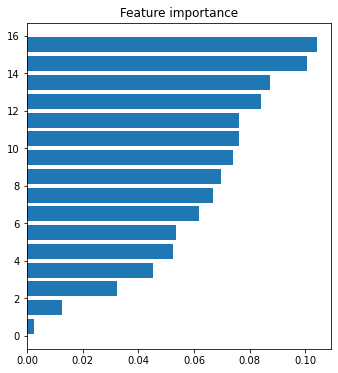

In [ ]:
print(RFC.predict(X_test))
print('F1 score:',RFC.score(X_train,y_train))

feature_importance = RFC.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.title('Feature importance')
plt.show()

In [ ]:
test['release_date'] = pd.to_datetime(test["release_date"])
test['release_date'] = pd.DatetimeIndex(test['release_date']).year-datetime.datetime(1970,1,1).year
X_challenge=test.to_numpy()

prediction_challenge = RFC.predict(X_challenge)


In [ ]:
# On obtient à nouveau le nom des genres avec la commande suivante 
prediction_challenge=le.inverse_transform(prediction_challenge)
prediction=pd.DataFrame(prediction_challenge,columns=['genre'])

In [ ]:
prediction.to_csv(PATH+'/TAN_MELLE-VUILLOD.csv')

Adaboost ne semble pas être un modèle convaincant qui réalise un score plus faible qu'un seul arbre de décision.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
ada.fit(X_train, y_train)
print(ada.predict(X_test))
print(ada.score(X_test,y_test))
0


[ 5 18 13 ...  6 10 12]
0.26691508138850756
0.2666601284754573
[0.19 0.01 0.   0.02 0.15 0.   0.08 0.   0.01 0.25 0.26 0.   0.01 0.
 0.02 0.  ]


# 5. Entraînement d'un réseau de neurone pour classifier
Nous allons utiliser un réseau de neurones pour apprendre à classer les musiques. Dans un premier temps, nous allons utiliser un modèle simple multi-perceptron et puis dans un deuxième temps un CNN.

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_tr, test_size=0.2, random_state=42)


y_train = keras.utils.to_categorical(y_train, 22)

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(16,)),
        layers.Dense(50, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100,activation="relu"),
        layers.Dense(100,activation="relu"),
        layers.Dense(22, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                850       
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 22)                2222      
                                                                 
Total params: 28,372
Trainable params: 28,372
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import datetime
%load_ext tensorboard
!rm -rf ./logs/
%tensorboard --logdir logs/fit
log_dir = "logs/fit/" +"CIFAR10_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)


L'apprentissage de ce réseau reste bloqué dans un minimun local. Il faut peut -être centrer et réduire les données. Ce modèle n'est en tout cas pas concluant.

In [ ]:
batch_size = 32
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history=model.fit(np.float64(X_train), y_train, batch_size=batch_size, epochs=epochs,validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/50
574/574 [==============================] - 8s 13ms/step - loss: 710.7977 - accuracy: 0.0868 - val_loss: 3.0753 - val_accuracy: 0.2059
Epoch 2/50
574/574 [==============================] - 4s 7ms/step - loss: 3.0071 - accuracy: 0.2050 - val_loss: 2.9377 - val_accuracy: 0.2059
Epoch 3/50
574/574 [==============================] - 6s 10ms/step - loss: 2.8755 - accuracy: 0.2050 - val_loss: 2.8147 - val_accuracy: 0.2059
Epoch 4/50
574/574 [==============================] - 8s 14ms/step - loss: 2.7719 - accuracy: 0.2050 - val_loss: 2.7285 - val_accuracy: 0.2059
Epoch 5/50
574/574 [==============================] - 6s 10ms/step - loss: 2.7069 - accuracy: 0.2050 - val_loss: 2.6799 - val_accuracy: 0.2059
Epoch 6/50
574/574 [==============================] - 5s 9ms/step - loss: 2.6739 - accuracy: 0.2050 - val_loss: 2.6575 - val_accuracy: 0.2059
Epoch 7/50
574/574 [==============================] - 6s 11ms/step - loss: 2.6594 - accuracy: 0.2050 - val_loss: 2.6481 - val_accuracy: 0.2059

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv1D( 32,(2,), activation="relu",input_shape=(16,1)))
model2.add(layers.MaxPooling1D())
model2.add(layers.Conv1D( 32,(2,), activation="relu"))
model2.add(layers.MaxPooling1D())
model2.add(layers.Conv1D( 64,(2,), activation="relu"))
model2.add(layers.MaxPooling1D())
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(22,activation='softmax' ))

Ce réseau de neurones déjà un peu plus élaborer nous permet d'avoir un meilleur résultat mais qui converge vers un niveau de réussite un peu plus haut de 41% atteint lors de son apprentissage. C'est notre deuxième meilleur résultat obtenu.

In [ ]:
batch_size = 32
epochs = 200

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history=model2.fit(np.float64(X_train), y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/200
574/574 [==============================] - 13s 12ms/step - loss: 204.6833 - accuracy: 0.1865 - val_loss: 2.4614 - val_accuracy: 0.2608
Epoch 2/200
574/574 [==============================] - 7s 12ms/step - loss: 2.5391 - accuracy: 0.2402 - val_loss: 2.4249 - val_accuracy: 0.2696
Epoch 3/200
574/574 [==============================] - 6s 10ms/step - loss: 2.4509 - accuracy: 0.2530 - val_loss: 2.3830 - val_accuracy: 0.2696
Epoch 4/200
574/574 [==============================] - 7s 12ms/step - loss: 2.4232 - accuracy: 0.2625 - val_loss: 2.3621 - val_accuracy: 0.2735
Epoch 5/200
574/574 [==============================] - 4s 7ms/step - loss: 2.4005 - accuracy: 0.2662 - val_loss: 2.3353 - val_accuracy: 0.2887
Epoch 6/200
574/574 [==============================] - 5s 8ms/step - loss: 2.3756 - accuracy: 0.2718 - val_loss: 2.2867 - val_accuracy: 0.3005
Epoch 7/200
574/574 [==============================] - 6s 11ms/step - loss: 2.3534 - accuracy: 0.2772 - val_loss: 2.2810 - val_accuracy

# 2. Prédiction de la popularité
### Pour cette partie, nous avons décidé d'utilisé un réseau de neurone et un modèle de régression fournie par XGBoost. Mais on va tout d'abord, transformer les données pour qu'elles soient manipulable par les différents modèles.
### Nous gérons la 'release_date' comme précedemment. Pour les artistes, nous avons utilisés un labelencoder pour obtenir un sorte d'ID, car on sait très bien que la popularité d'une musique dépend aussi de l'artiste.

### Pour garder la colonne 'genres', nous avons  déterminer une moyenne de popularité par genre qui est calculée de la façon suivante. Nous allons utilisé des dictionnaires (counter) qui vont stocké la somme des popularités dont le genre apparaît dans la colonne 'genres'. Puis nous n'avons plus qu'à diviser chacune des sommes par le nombre d'occurences du genre en question.
### Enfin, nous allons considérer un score de 'genre' qui serait la moyenne des genres avec les scores obtenus à l'étape précédente.

### Pour terminer, nous avons décidé de ne pas tenir compte du titre et de l'id pour une musique qui, selon nous, n'affecteront la popularité de façon minime.

In [ ]:
import math
subset=pd.read_csv(PATH+'/spotify_dataset_subset.csv')

genre_list=subset['genres']
popularity=subset['popularity'].to_numpy()
from collections import Counter
j=0
cnt_popularity = Counter()
cnt_occurence = Counter()
#On parcourt une première fois, notre dataset pour récupérer la somme des popularités pour chaque genre et aussi le nombre d'occurences du genre.
for i in range(genre_list.shape[0]):
  for genre in genre_list[i][1:-1].split(','):
    cnt_popularity[genre] += popularity[i]
    cnt_occurence[genre] += 1 

for key,value in cnt_popularity.items():
  cnt_popularity[key] = cnt_popularity[key]/cnt_occurence[key]

#Ici, nous calulons la moyenne des "scores de popularités des genres qui apparaissent"
for i in range(subset.shape[0]):
  subset['genres'][i] = subset['genres'][i][1:-1].split(',')
  score_popularity_genre=0
  for genre in subset['genres'][i]:
    score_popularity_genre += cnt_popularity[genre]
  subset['genres'][i] = score_popularity_genre / len(subset['genres'][i]);

y_sub = subset['popularity'].to_numpy()

le = preprocessing.LabelEncoder()
le.fit(subset['artist_name'])
subset['artist_name'] = le.transform(subset['artist_name'])
artistes = le.classes_
subset['release_date'] = pd.to_datetime(subset["release_date"])
subset['release_date'] = pd.DatetimeIndex(subset['release_date']).year-datetime.datetime(1970,1,1).year

X_sub = subset.drop(['popularity','track_name','id'],axis=1).to_numpy()


X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)




<ipython-input-14-e24f8f6180bc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['genres'][i] = subset['genres'][i][1:-1].split(',')
<ipython-input-14-e24f8f6180bc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['genres'][i] = score_popularity_genre / len(subset['genres'][i]);


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(17,)),
        layers.Dense(100,activation="relu"),
        layers.Dense(100,activation="relu"),
        layers.Dense(1, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               1800      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


La fonction d'apprentissage tombe encore une fois un minimum local. Nous n'obtenons donc pas des résultats exploitables.

In [ ]:
batch_size = 32
epochs = 10

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

history=model.fit(np.float64(X_sub_train), y_sub_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/10
174/174 [==============================] - 2s 9ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 2/10
174/174 [==============================] - 3s 18ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 3/10
174/174 [==============================] - 1s 3ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 4/10
174/174 [==============================] - 2s 9ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 5/10
174/174 [==============================] - 1s 3ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 6/10
174/174 [==============================] - 1s 5ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_loss: 1470.8578 - val_accuracy: 0.0180
Epoch 7/10
174/174 [==============================] - 1s 9ms/step - loss: 1454.9387 - accuracy: 0.0187 - val_lo

### Par la méthode XGB, nous obtenons MAE plutôt satisfaisant permettant de mesurer l'écart de nos valeurs prédites et les vraies valeurs. L'écart semble plûtot faible, on aurait donc une bonne prédiction selon ce score.

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

XGBModel = xgb.XGBRegressor()
XGBModel.fit(X_sub_train,y_sub_train , verbose=False)

XGBpredictions = XGBModel.predict(X_sub_test)
MAE = mean_absolute_error(y_sub_test , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[16:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  16.03090844123528


## Conclusion :
### Nous pourrions avoir un MAE plus faible en ayant set plus grand. En effet, la colonne 'artiste' et la colonne 'genres' seraient beaucoup plus significatif, notamment sur la précision des scores de popularité par genre mais aussi sur l'influence de l'artiste. Puisque, nous avons une diversité d'artistes et de genres qui est énorme comparer à notre subset.

# Recommendation

In [ ]:
recommendation

acousticness                             artists  danceability  \
0           0.991000                     ['Mamie Smith']         0.598   
1           0.643000           ["Screamin' Jay Hawkins"]         0.852   
2           0.993000                     ['Mamie Smith']         0.647   
3           0.000173                 ['Oscar Velazquez']         0.730   
4           0.295000                            ['Mixe']         0.704   
...              ...                                 ...           ...   
174384      0.009170  ['DJ Combo', 'Sander-7', 'Tony T']         0.792   
174385      0.795000                    ['Alessia Cara']         0.429   
174386      0.806000                       ['Roger Fly']         0.671   
174387      0.920000                    ['Taylor Swift']         0.462   
174388      0.239000                       ['Roger Fly']         0.677   

        duration_ms  energy  explicit                      id  \
0            168333   0.224         0  0cS0A1fUEUd1EW3FcF8AEI   
1            150200   0.517         0  0hbkKFIJm7Z05H8Zl9w30f   
2            163827   0.186         0  11m7laMUgmOKqI3oYzuhne   
3            422087   0.798         0  19Lc5SfJJ5O1oaxY0fpwfh   
4            165224   0.707         1  2hJjbsLCytGsnAHfdsLejp   
...             ...     ...       ...                     ...   
174384       147615   0.866         0  46LhBf6TvYjZU2SMvGZAbn   
174385       144720   0.211         0  7tue2Wemjd0FZzRtDrQFZd   
174386       218147   0.589         0  48Qj61hOdYmUCFJbpQ29Ob   
174387       244000   0.240         1  1gcyHQpBQ1lfXGdhZmWrHP   
174388       197710   0.460         0  57tgYkWQTNHVFEt6xDKKZj   

        instrumentalness  key  liveness  loudness  mode  \
0               0.000522    5    0.3790   -12.628     0   
1               0.026400    5    0.0809    -7.261     0   
2               0.000018    0    0.5190   -12.098     1   
3               0.801000    2    0.1280    -7.311     1   
4               0.000246   10    0.4020    -6.036     0   
...                  ...  ...       ...       ...   ...   
174384          0.000060    6    0.1780    -5.089     0   
174385          0.000000    4    0.1960   -11.665     1   
174386          0.920000    4    0.1130   -12.393     0   
174387          0.000000    0    0.1130   -12.077     1   
174388          0.891000    7    0.2150   -12.237     1   

                                                     name  popularity  \
0                                Keep A Song In Your Soul          12   
1                                    I Put A Spell On You           7   
2                                            Golfing Papa           4   
3       True House Music - Xavier Santos & Carlos Gomi...          17   
4                                               Xuniverxe           2   
...                                                   ...         ...   
174384                                            The One           0   
174385                                      A Little More           0   
174386                                           Together           0   
174387                                 champagne problems          69   
174388                                     Improvisations           0   

       release_date  speechiness    tempo  valence  year  
0              1920       0.0936  149.976   0.6340  1920  
1        1920-01-05       0.0534   86.889   0.9500  1920  
2              1920       0.1740   97.600   0.6890  1920  
3        1920-01-01       0.0425  127.997   0.0422  1920  
4        1920-10-01       0.0768  122.076   0.2990  1920  
...             ...          ...      ...      ...   ...  
174384   2020-12-25       0.0356  125.972   0.1860  2020  
174385   2021-01-22       0.0360   94.710   0.2280  2021  
174386   2020-12-09       0.0282  108.058   0.7140  2020  
174387   2021-01-07       0.0377  171.319   0.3200  2021  
174388   2020-12-09       0.0258  112.208   0.7470  2020  

[174389 rows x 19 columns]

### Etablissement des colonnes importantes pour déterminer une playlist à partir des critères d'une musique

In [ ]:
colonnes_utiles=['acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','popularity','speechiness','tempo','valence','year']
indices_des_colonnes_utiles=[0,2,3,4,5,7,8,9,10,11,13,15,16,17,18]
recommendation_utile=recommendation[colonnes_utiles]

### Récupération des maximums et minimums des colonnes utiles pour normaliser les données

In [ ]:
def minimum(colonne):
  mini=recommendation[colonne][0]
  for elt in recommendation[colonne]:
    if elt<=mini:
      mini=elt
  return mini

def maximum(colonne):
  maxi=recommendation[colonne][0]
  for elt in recommendation[colonne]:
    if elt>=maxi:
      maxi=elt
  return maxi

les_min=[minimum(colonne) for colonne in colonnes_utiles]
les_max=[maximum(colonne) for colonne in colonnes_utiles]

### Construction d'un tableau avec les valeurs normalisées (entre 0 et 1) pour l'ensemble des données du fichier "recommendation".

In [ ]:
recommendation_normalisee_pas_dataframe=[]
for k in range(len(recommendation['key'])):
  musique_k=[]
  for i in range(len(colonnes_utiles)):
    musique_k.append((recommendation_utile[colonnes_utiles[i]][k]-les_min[i])/(les_max[i]-les_min[i]))
  recommendation_normalisee_pas_dataframe.append(musique_k)

### Déterminer les musiques dites proches de la musique en entrée. Pour cela, on regarde les "distances" entre les valeurs de la musique d'entrée, pour chaque colonnes utiles, et les valeurs normalisées de toutes les autres musiques du fichier "recommendation".

In [ ]:
def musique_proche(musique): # Dans le cas d'une liste de musique, on pourrait adapter en prenant la "moyenne" des valeurs des musiques de la playlist
  distances=[]
  for k in range(len(recommendation['acousticness'])):
    distance=0
    for i in range(len(colonnes_utiles)):
      musique_normalisee=(musique[indices_des_colonnes_utiles[i]]-les_min[i])/(les_max[i]-les_min[i])
      distance+=np.abs(recommendation_normalisee_pas_dataframe[k][i]-musique_normalisee)
    distances.append(distance)
  return distances

### Recherche des 10 musiques les plus proches pour l'établissement de la playlist.

In [ ]:
def les_10_plus_proches(musique):
  proches=[]
  d=musique_proche(musique)
  d_triees=d[::]
  d_triees.sort()
  d_10=d_triees[1:11]
  for k in range(len(recommendation['key'])):
    if d[k] in d_10:
      proches.append(k)
  return proches

In [ ]:
indice_musique_aleatoire=int(np.random.random()*len(recommendation['key']))
print(indice_musique_aleatoire)
print(recommendation.values[indice_musique_aleatoire][1])
valeur=les_10_plus_proches(recommendation.values[indice_musique_aleatoire])
print(valeur)
for k in range(10):
  print(recommendation.values[valeur[k]][1])

115388
['Bobby Vinton']
[64155, 65192, 99095, 99126, 99879, 114944, 115354, 131911, 132166, 147737]
['Johnny Horton']
['Alvin & The Chipmunks']
['Brenda Lee']
['Tammy Wynette']
['Tammy Wynette']
['Elvis Presley', 'The Jordanaires']
['Bobby Vinton']
['Hank Locklin']
['Judy Collins']
['Bobby Vinton']


### Cependant, ce modèle reste limité. Suivant les utilisateurs, d'autres critères peuvent être plus ou moins important. Par exemple, l'artiste, qui n'est pas pris en compte ici ou encore si quelqu'un ne souhaite écouter que des musiques dites populaires. On pourrait rajouter des poids aux colonnes pour leurs donner plus ou moins d'importance dans l'établissement de la playlist.

### Question 2 : Pour prendre en compte tous les utilisateurs, on pourrait rajouter une colonne avec le nombre d'écoute d'une musique en fonction des utilisateurs pour lesquels est établit la playlist. Les vues peuvent aussi agir comme poids. Ou encore en reprenant la moyenne des écoutes de tous les utilisateurs.